In [11]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from scipy import array, linalg, dot
from decimal import Decimal
from scipy.special import expit

In [12]:
# Constants
rho0 = 2
g = 32.2
k = 2e4
R = 10 ** 4
Q = np.diag((0,0,0))

M = 10 ** 5
a = 10 ** 5

In [13]:
# Initial variables
x_list = [300000, -20000, 0.001]
x0 = np.asarray(x_list)[np.newaxis]
x0 = np.transpose(x0)
xhat = x0
xhat_ukf = xhat
x_post = x0

n = len(x0)
# Q = np.zeros((n,n))

P_post = np.diag((1e6,4e6,10))
P_ukf = P_post


In [14]:
# Time
# Time step
Ts = 0.5
# Simulation length
tf = 31
# Time step for integration
dt = 0.001
# Time vector
T_vec = np.arange(0,tf,Ts)
T_len = len(T_vec)
T_len

62

In [15]:
# Initialize variables
xArray = x0
xhatArray = xhat
xhatArray_ukf = xhat_ukf
xhatArray_ukf_2 = []
Parray = np.diag(P_post)
Parray_ukf = np.diag(P_ukf)
xlst_alt = []
xlst_vel = []
xlst_bal = []
xdot_list = []
x_post_alt = np.zeros((T_len,2))
x_post_alt[0,0:2] = x0[0].T
x_post_vel = np.zeros((T_len,2))
x_post_vel[0,0:2] = x0[1].T

In [16]:
# UKF weights
W = np.ones((6,1)) / 6


In [17]:
y = np.zeros((T_len,1))
x = np.zeros((T_len,3))
x[0,:] = x0.T

for b in range(0,2):

    for i in range(1,T_len):
        # Sigma points
        sigma= np.ones((6,3))
    #     P_post = P_ukf
        pp3 = np.dot(P_post,P_post.T)
        pp = np.linalg.svd(2*n*pp3)
        for j in range(0,3):
        #     root = pp[1*i,1*i]
            sigma[j,:] = xhat_ukf.T +  pp[0::][0][j]
            sigma[3+j,:] = xhat_ukf.T -  pp[0::][0][j]
    #         sigma[j,:] = x_prior.T + pp[j,:]
    #         sigma[3+j,:] = x_prior.T - pp[j,:]

        x_prior = np.zeros((3,1))
        P_post = P_post +  Q

        xsigma_prior = np.zeros((6,3))
        for m in range(0,2*n):
            xx = sigma[m,:]
            x_nxt = np.asarray(np.zeros((3,1)))
            for _ in range(0,500):
                x_nxt[0] = xx[0] + xx[1]*Ts
                x_nxt[1] = xx[1] + Ts*rho0*np.exp(-xx[0]/k)*xx[1]**2/1 * xx[2]/2 - g*Ts
                x_nxt[2] = xx[2] + np.abs(Ts**b - Ts)

    #         print(x_nxt)

            xsigma_prior[m,:] = np.asarray(x_nxt.T)
            x_prior = x_prior + (xsigma_prior[m,:]/6).reshape(3,1) 
    #         print(x_prior)

        for m in range(0,2*n):
            error = xsigma_prior[m,:] - x_prior
            P_post = P_post + (error * error.T)/6

        P_post = (P_post + P_post.T)/6

        # System Evolution
        x_nxt = np.ones((3,1))
        xx = x[i-1,:]
    #     print(xx)
    #     print(x[i-1].T)
        x_nxt = np.zeros((3,1))
        for _ in range(0,500):
            x_nxt[0,0] = xx[0] + xx[1]*Ts
            x_nxt[1,0] = xx[1] + Ts*rho0*np.exp(-xx[0]/k)*xx[1]**2/1 * xx[2]/2- Ts*g
            x_nxt[2,0] = xx[2] + np.abs(Ts**b - Ts)
    #     print(x_nxt.T)
        x[i,:] = x_nxt.T

        # Measurement update
        y[i] = np.sqrt(M**2 + (x[i][b]-a)**2) + R

        # Sigma points
        x_sigma_prior= np.ones((6,3))
        pp4 = np.dot(P_post,P_post.T)
        pp = np.linalg.svd(2*n*pp4)
    #     pp1 = pp[2].tolist()
    #     print(pp[0])
        for j in range(0,3):
        #     root = pp[1*i,1*i]
            x_sigma_prior[j,:] = x_prior.T + pp[0::][0][j]
            x_sigma_prior[3+j,:] = x_prior.T - pp[0::][0][j]
    #         x_sigma_prior[j,:] = x_prior.T + pp[j,:]
    #         x_sigma_prior[3+j,:] = x_prior.T - pp[j,:]

        y_avg = 0
        y_sigma = np.zeros((6,1))
        for m in range(0,2*n):
            y_sigma[m] = np.sqrt(M**2 + (x_sigma_prior[m][b]-a)**2) + np.sqrt(0)*np.random.randn() + R
            y_avg = y_avg + y_sigma[m]/6

        Py = 0
        Pxy = np.zeros((n,1))
        for m in range(0,2*n):
            y_error = (y_sigma[m] - y_avg)
            x_error = (x_sigma_prior[m,:] - x_prior)
            Py = Py + np.dot(y_error,y_error.T)/6
            Pxy = Pxy + np.multiply(x_error,y_error)/6

        Py = (Py + Py.T)/6 

        # Calculate Kalman Gain
        K = Pxy/Py
        innov = y[i] - y_avg
    #     print(innov)
    # np.multiply(K,innov)
        x_post= (np.multiply(np.diag(K),innov).reshape(3,1) + x_prior.T)/1
#         x_post_vel.append(x_post[:,1])
        P_post = P_post - np.multiply(K, np.multiply(Py, K.T))
#         P_post = np.multiply(P_post,P_post.T)/2
        P_post = (P_post + P_post.T)/6
        x_post_alt[i,b] = (np.sum(x_post[:,0]))/(2*n**(b-1)) 
        x_post_vel[i,b] = np.sum(x_post[:,1])/(2*n**(b-1)) 
# print(x_prior)  
# print(innov)
# print(x_post)   
# np.dot(K,innov)  
# x_prior
# aa22.T
# x_sigma_prior
# np.linalg.cholesky(P_prior)
# print(P_ukf)
# print(P_prior)
# print(np.diag(P_prior))
# np.multiply(np.diag(K),innov).reshape(3,1) + x_prior
# x_prior
# np.multiply(K, np.multiply(Py, K.T))
# x_post[0,
# print(np.sum(x_post[1:,1]))
# print(x_post)
# print(pp1)
# print(pp)
# print(pp)
# print(pp[0::][0][0] + x_prior.T)
# print(pp[0::][0][1] + x_prior.T)
# # print(x_prior.T)
# pp[0::][j][0]
# print(x_post[:,0])
# print(x_post_vel[:,1])
x_post_alt[1:,0] = x_post_alt[1:,0]/(2*n)
print(np.sum(x_post_alt))
# print(Py)
# print(x_post_alt)


38022551.56932105


In [18]:
# # pp = np.linalg.cholesky(3*P_ukf)
# P_prior
# pp
# P_ukf
# # asa = np.diag([P_prior[0],P_prior[1],P_prior[2]])
# # asa = np.array([[P_prior[0],0,0],[0,P_prior[1],0],[0,0,P_prior[2]]])
# pp = np.linalg.cholesky(np.multiply(3,np.diag(P_prior)))


In [19]:
# xlst_alt = []
# xlst_vel = []
# for h in range(0,T_len-1):
#     xlst_alt.append(np.sum(x_post_alt[h]))
#     xlst_vel.append(np.sum(x_post_vel[h]))
# len(xlst_vel)

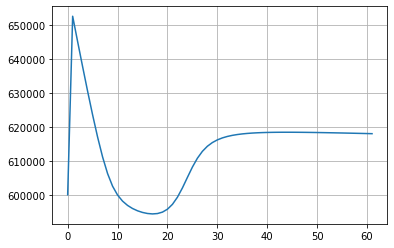

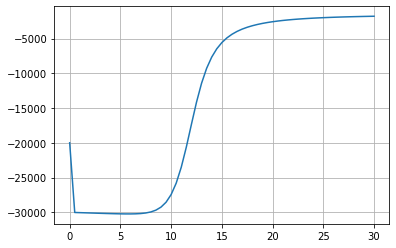

In [20]:
plt.figure(1)
altitude_0 = np.abs((x_post_alt[:,0]+x_post_alt[:,1])/1)
# altitude = altitude_0[altitude_0 <= 300000]
plt.plot(altitude_0)
# plt.plot(T_vec[0],(x_post_alt[0,0]+x_post_alt[0,0])/2,T_vec[0:T_len-1], T_vec[0:T_len-1], np.abs((x_post_alt[1:,0]+x_post_alt[1:,1])/2))
# plt.plot(T_vec[0],(x_post_alt[0,0]+x_post_alt[0,0])/2,T_vec[0:T_len-1], np.abs((x_post_alt[1:T_len,0]+x_post_alt[1:T_len,1])/1))
# plt.scatter(T_vec[0:T_len], x_post_alt[:,1])
plt.ticklabel_format(useOffset=False)
plt.grid()

plt.figure(2)
plt.plot(T_vec[0:T_len-1], x_post_vel[:T_len-1,1])
plt.ticklabel_format(useOffset=False)
plt.grid()
# print(np.sum(x_post_list[0]))
# print(np.sum(x_post_list[1]))
# print(x_post_list)

